In [1]:
import torch
import matplotlib.pyplot as plt
import tqdm
import utils
import dataloaders
import numpy as np
import torchvision
import os
from trainer import Trainer
torch.random.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cuda.deterministic = True

### Model Definition

In [2]:
def layer(in_channels, out_channels):
    K_C, S_C, P_C = 5, 1, 2
    K_M, S_M, P_M = 2, 2, 0
    
    seq = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=K_C, stride=S_C, padding=P_C),
        torch.nn.ReLU(), 
        torch.nn.MaxPool2d(kernel_size=K_M, stride=S_M, padding=P_M),
    )
    
    return seq

class LeNet(torch.nn.Module):

    def __init__(self):
        super().__init__()
        
        ### START YOUR CODE HERE ### (You can change anything inside this block)
        num_input_nodes = 32*32
        num_hidden_nodes = 64
        num_classes = 10
        
        C_0, C_1, C_2, C_3 = 1, 32, 64, 128
        
        
        self.layer1 = layer(C_0, C_1)
        
        self.layer2 = layer(C_1, C_2)
        
        self.layer3 = layer(C_2, C_3)
        
        self.flat = torch.nn.Sequential(
            torch.nn.Flatten(1),
        )
        
        self.layer4 = torch.nn.Sequential(
            torch.nn.Linear(4 * 4 * C_3, num_hidden_nodes), 
            torch.nn.ReLU(),
        )
        
        self.layer5 = torch.nn.Sequential(
            torch.nn.Linear(num_hidden_nodes, num_classes)  
        )
        ### END YOUR CODE HERE ### 

    def forward(self, x):
        ### START YOUR CODE HERE ### (You can change anything inside this block) 
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.flat(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x
        ### END YOUR CODE HERE ### 


### Hyperparameters & Loss function

In [8]:
# Hyperparameters
batch_size = 64
learning_rate = 0.0192
num_epochs = 10


# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

### Train model

In [9]:


image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.25])
])
dataloader_train, dataloader_val = dataloaders.load_dataset(batch_size, image_transform)

# Model definition
model = LeNet()
# Transfer model to GPU memory (if possible)
model = utils.to_cuda(model)

# Define optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)
trainer = Trainer( 
  model=model,
  dataloader_train=dataloader_train,
  dataloader_val=dataloader_val,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict, val_loss_dict = trainer.train(num_epochs)

Training epoch 9: 100%|██████████| 938/938 [00:57<00:00, 16.33it/s]


### Train Model

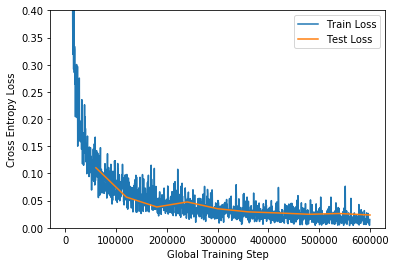

In [10]:
utils.plot_loss(train_loss_dict, label="Train Loss")
utils.plot_loss(val_loss_dict, label="Test Loss")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, .4])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
os.makedirs("image_processed", exist_ok=True)
if num_epochs == 4:
    plt.savefig(os.path.join("image_processed", "task2_b.png"))
if num_epochs == 10:
    plt.savefig(os.path.join("image_processed", "task2_c.png"))

plt.show()

torch.save(model.state_dict(), "saved_model.torch")


In [11]:

# %%
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_val, model, loss_function)
print(f"Final Validation loss: {final_loss}. Final Validation accuracy: {final_acc}")

# %%

Final Validation loss: 0.023527828954214854. Final Validation accuracy: 0.9917


In [12]:
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_train, model, loss_function)
print(f"Final Train loss: {final_loss}. Final Train accuracy: {final_acc}")

Final Train loss: 0.011397973218215578. Final Train accuracy: 0.9968666666666667
